# Investigating the role of pre-miRNA concentration on competition

Using same model as for the investigations into the competition effects between 8 theoretical pre-miRNAs

## Set up workspace

In [1]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
import seaborn as sns
import matplotlib.style as style
import matplotlib.colors as mcolors
from matplotlib import rcParams
style.use('seaborn-colorblind')

In [2]:
destdir_csvs = './outputs/premir-conc-vars/csvs/'
destdir_figs = './outputs/premir-conc-vars/plots/'

## Helper functions

In [86]:
##ODE maker for control condition, specific for this notebook
def makeControlODEs(init_values, ka, kb, kc, kd):
    """
    Function to generate string of functions for passing to ODE solver, separate Dicer 
    populations for each
    
    init_values:    List of initial concentration of free pre-miRNA concentration for
                    each pre-mirna, pre-mirna x dicer concentration, pre-mirna x dicer* 
                    concentration, mirna concentration, and dicer concentration. 
                    Alternating pre-mirna (a), pre-mirna dicer (b), pre-mirna dicer* (c)
                    and mirna(d), with final dicer concentration (e), i.e. 
                    [a, b, c, d, e, a, b, c, d, e].
    ka:             Array of reaction rates for formation of pre-miR - dicer commplex
    kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
    kc:             Array of reaction rates for formation of pre-miR - dicer complex 
    kd:             Array of reaction rates for catalysis of pre-miR to miR by dicer
    
    Outputs a string with all functions separated by new lines.
    """
    
    
    #calculate number of miRNAs
    n_mirna = int((len(init_values))/5)
    output = ""
    names = ""
    concs = ""
    dicer_strings = "        dicer = "
    
    #create system
    j = 0
    for i in range(n_mirna):
        
        #init_values[0] = pMiR
        #init_values[1] = pMiR_dicer
        #init_values[2] = pMiR_dicer_star >> never in ODE, needed for solver
        #init_values[3] = miR >> never in ODE, needed for solver
        #init_values[-1] = dicer

        output = output + '\n\n        premirna' + str(i) + ' = init_values[' + str(j+1) + '] * kb[' + str(i) + '] - init_values[' + str(j) + '] * init_values['  + str(j+4) + '] * (ka[' + str(i) + '] + kc[' + str(i) + '])' + '\n        pmiR_dicer' + str(i) + ' = init_values[' + str(j) + '] * init_values['  + str(j+4) + '] * ka[' + str(i) + '] - init_values[' + str(j+1) + '] * (kb[' + str(i) + '] + kd[' + str(i) + '])' + '\n        pmiR_dicer_star' + str(i) + ' = init_values[' + str(j) + '] * init_values['  + str(j+4) + '] * kc[' + str(i) + ']' + '\n        mirna' + str(i) + ' = init_values[' + str(j+1) + '] * kd[' + str(i) + ']'
        
        dicer_strings = "        dicer" + str(i) + " = "
        dicer_strings = dicer_strings + 'init_values[' + str(j+1) + '] * (kb[' + str(i) + '] + kd[' + str(i) + ']) - init_values['  + str(j+4) + '] * init_values[' + str(j) + '] * (ka[' + str(i) + '] + kc[' + str(i) + '])'
        if i < n_mirna - 1:
            names = names + 'premirna' + str(i) + ', pmiR_dicer' + str(i) + ', pmiR_dicer_star' + str(i) + ', mirna' + str(i) + ', dicer' + str(i) + ', '
        else:
            names = names + 'premirna' + str(i) + ', pmiR_dicer' + str(i) + ', pmiR_dicer_star' + str(i) + ', mirna' + str(i) + ', dicer' + str(i)

        
        j += 5
    
        output = output +'\n' + dicer_strings
    
    return output, names

In [89]:
print(model_control)

def runModel(t, init_values, ka, kb, kc, kd):
        """
        Function to run model in ODE solver
        
        Function to generate string of functions for passing to ODE solver
    
        init_values:    List of initial concentration of free pre-miRNA concentration for
                        each pre-mirna, pre-mirna x dicer concentration, pre-mirna x dicer* 
                        concentration, mirna concentration, and dicer concentration. 
                        Alternating pre-mirna (a), pre-mirna dicer (b), pre-mirna dicer* (c)
                        and mirna(d), with final dicer concentration (e), i.e. 
                        [a, b, c, d, a, b, c, d, e]. Can be automatically generated with fun
                        make_inits().
        ka:             Array of reaction rates for formation of pre-miR - dicer commplex
        kb:             Array of reaction rates for dissociation of pre-miR - dicer complex
        kc:             Array of reaction rates for fo

## Generate model

In [4]:
#make 2 miRNA model
ODE_inits = [0]*8*4 + [0]
ODE_ka = [0] * 8
ODE_kb = ODE_ka
ODE_kc = ODE_ka
ODE_kd = ODE_ka

In [5]:
ode = mu.makeODEs(ODE_inits, ODE_ka, ODE_kb, ODE_kc, ODE_kd)

In [6]:
model = mu.makeModel(ode)

In [88]:
#control model
ode_control = makeControlODEs([0]*5*8, [0]*8, [0]*8, [0]*8, [0]*8)
model_control = mu.makeModel(ode_control)

## Set up conditions for models

In [8]:
high = 10
low = 1
k = 2

In [9]:
inits1 = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, params.init_MiR1] * 8

In [10]:
ka = [params.ka1 * high, params.ka1 * low] + [params.ka1] * 2 +\
     [params.ka1 * high * k, params.ka1 * low] + [params.ka1 * k] * 2

kb = [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high]  + \
    [params.ka1 * params.Kd_wt] * 2 + \
    [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high * k] +\
    [params.ka1 * params.Kd_wt] * 2

kc = [params.kc1] * 2 + [params.kc1 * high, params.kc1] + \
     [params.kc1] * 2 + [params.kc1 * high * k, params.kc1]

kd = [params.kd1] * 3 + [params.kd1 * high] + [params.kd1] * 3 + [params.kd1 * high * k]

In [11]:
#Dicer concentration variations
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))
variations = [str(int(i * 100)) for i in list(dvars)]

In [12]:
#pre-miRNA concentration variations
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
p_variations = [str(int(i*100)) for i in list(dvars)]

## Run model, save outputs

In [143]:
exec(model)

In [144]:
names = []
for ii in tqdm(range(len(dvars))):
    for ij in range(0, int(8*4), 4):
        for ik in range(len(pvars)):
            name = 'model_d' + variations[ii] + '_miR' + str(int(ij/4)) + '_' + p_variations[ik]
            
            init = inits1 + [dvars[ii]]
            init[ij] = init[ij] * pvars[ik]
            
            res = solve_ivp(runModel, (0, int(params.minutes)), init, \
                            args = (ka, kb, kc, kd), method = 'LSODA')
    
            mirna_length = int((len(res.y)-1)/4)
            index = []
    
            for j in range(mirna_length):
                index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                                 'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
            index = index + ['dicer']
    
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
    
            names.append(name)
    
            df.to_csv(destdir_csvs + name + '.csv', index = False)

df1 = pd.DataFrame({'names': names})
df1.to_csv(destdir_csvs + 'names.csv', index = False)

100%|██████████| 19/19 [00:38<00:00,  2.02s/it]


In [90]:
exec(model_control)

In [91]:
names_control = []
for ij in tqdm(range(0, int(8*5), 5)):
    for ii in range(len(dvars)):
        for ik in range(len(pvars)):
            name = 'model_d' + variations[ii] + '_miR' + str(int(ij/5)) + '_' + p_variations[ik] + '_control'
            
            init = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1, params.init_dcr1] * 8
            init[ij + 4] = dvars[ii]
            init[ij] = init[ij] * pvars[ik]
            
            res = solve_ivp(runModel, (0, int(params.minutes)), init, \
                            args = (ka, kb, kc, kd), method = 'LSODA')
    
            mirna_length = int(len(res.y)/5)
            index = []
    
            for j in range(mirna_length):
                index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                                 'pMiR_dicer_star' + str(j), 'miR' + str(j),\
                                 'dicer' + str(j)]
    
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
    
            names_control.append(name)
    
            df.to_csv(destdir_csvs + name + '.csv', index = False)

df2 = pd.DataFrame({'names': names_control})
df2.to_csv(destdir_csvs + 'control_names.csv', index = False)

100%|██████████| 8/8 [00:41<00:00,  5.23s/it]


## Plotting

In [92]:
#load data (for restarting notebook)
names = pd.read_csv(destdir_csvs + 'names.csv')
names = list(names['names'])
control_names = pd.read_csv(destdir_csvs + 'control_names.csv')
control_names = list(control_names['names'])

In [93]:
#prep data for plotting
##read data
for name in tqdm(names):
    exec(name + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')
for control_name in tqdm(control_names):
    exec(control_name + ' = pd.read_csv("' + destdir_csvs + control_name + '.csv", header = [0])')

100%|██████████| 1976/1976 [00:22<00:00, 89.72it/s]


In [94]:
#prep end points for plotting
##[pMiR that's varied][pMiR concentrations][Dicer concentrations]
ends = {'miR0_changed': np.zeros((8, len(pvars), len(dvars))), 'miR1_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR2_changed': np.zeros((8, len(pvars), len(dvars))), 'miR3_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR4_changed': np.zeros((8, len(pvars), len(dvars))), 'miR5_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR6_changed': np.zeros((8, len(pvars), len(dvars))), 'miR7_changed': np.zeros((8, len(pvars), len(dvars)))}
control_ends = {'miR0_changed': np.zeros((8, len(pvars), len(dvars))), 'miR1_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR2_changed': np.zeros((8, len(pvars), len(dvars))), 'miR3_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR4_changed': np.zeros((8, len(pvars), len(dvars))), 'miR5_changed': np.zeros((8, len(pvars), len(dvars))),
        'miR6_changed': np.zeros((8, len(pvars), len(dvars))), 'miR7_changed': np.zeros((8, len(pvars), len(dvars)))}

for k in tqdm(range(8)):
    for j in range(len(pvars)):
        for i in range(len(dvars)):
            exec('miR = model_d' + variations[i] + '_miR' + str(k) + '_' + p_variations[j])
            exec('control_miR = model_d' + variations[i] + '_miR' + str(k) + '_' + p_variations[j] + '_control')
            ends['miR' + str(k) + '_changed'][0][j][i] = miR['miR0'].iloc[-1]
            ends['miR' + str(k) + '_changed'][1][j][i] = miR['miR1'].iloc[-1]
            ends['miR' + str(k) + '_changed'][2][j][i] = miR['miR2'].iloc[-1]
            ends['miR' + str(k) + '_changed'][3][j][i] = miR['miR3'].iloc[-1]
            ends['miR' + str(k) + '_changed'][4][j][i] = miR['miR4'].iloc[-1]
            ends['miR' + str(k) + '_changed'][5][j][i] = miR['miR5'].iloc[-1]
            ends['miR' + str(k) + '_changed'][6][j][i] = miR['miR6'].iloc[-1]
            ends['miR' + str(k) + '_changed'][7][j][i] = miR['miR7'].iloc[-1]
            
            control_ends['miR' + str(k) + '_changed'][0][j][i] = control_miR['miR0'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][1][j][i] = control_miR['miR1'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][2][j][i] = control_miR['miR2'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][3][j][i] = control_miR['miR3'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][4][j][i] = control_miR['miR4'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][5][j][i] = control_miR['miR5'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][6][j][i] = control_miR['miR6'].iloc[-1]
            control_ends['miR' + str(k) + '_changed'][7][j][i] = control_miR['miR7'].iloc[-1]

100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


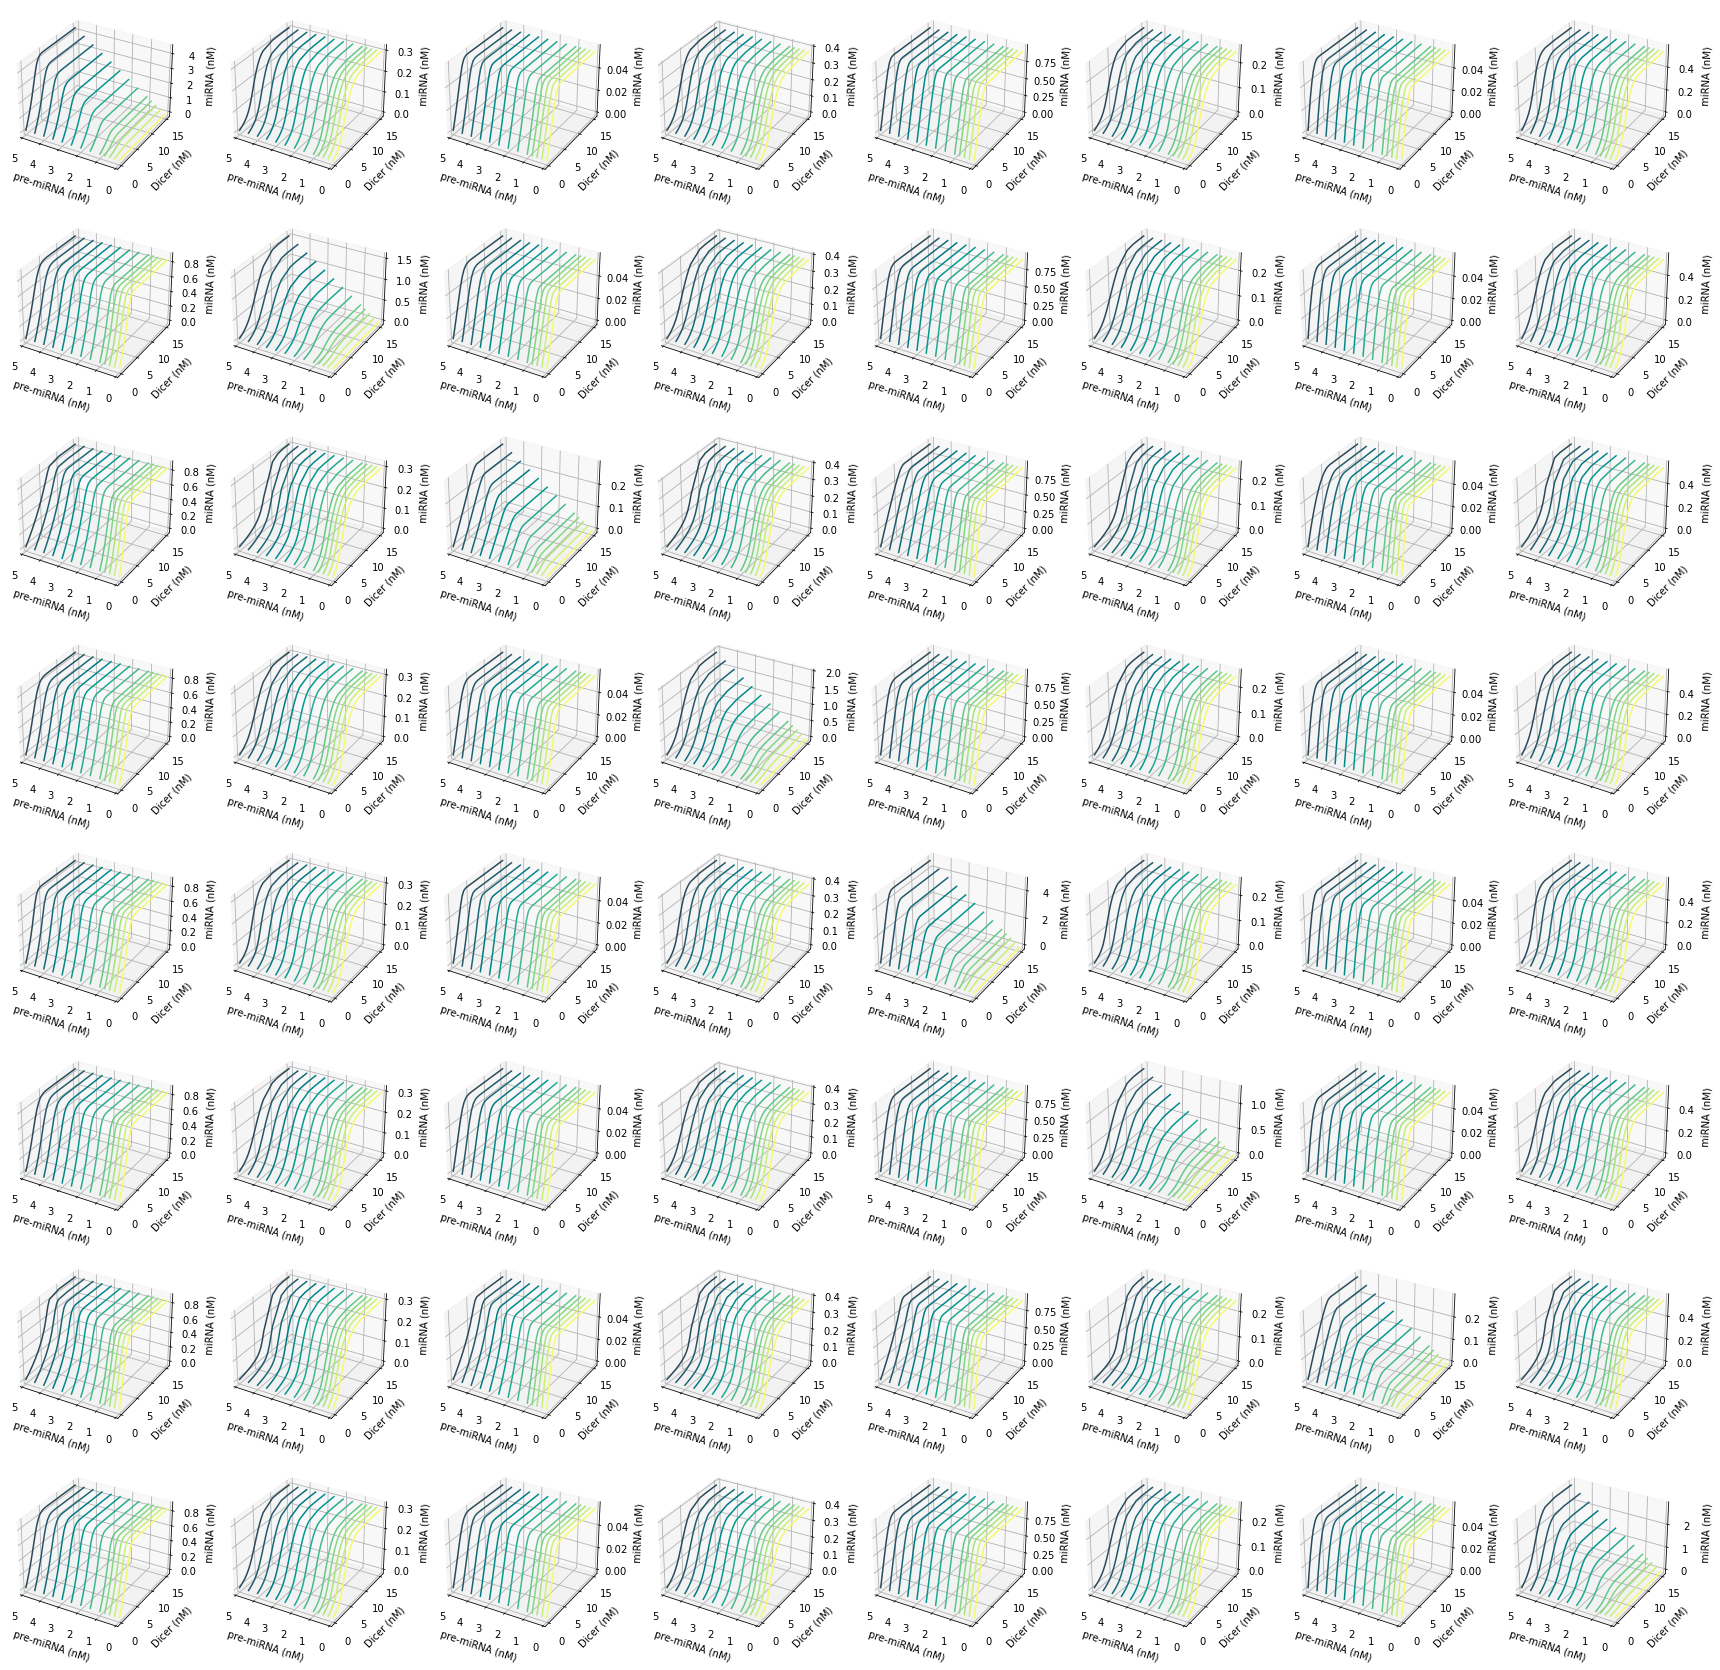

In [16]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))

color_gradient = ["#f5fa6e", "#ccf073", "#a6e47a", "#82d781", "#61c888", "#40b98d", "#1fa990",
                  "#00998f", "#00888b", "#007883", "#176777", "#245769", "#2a4858"]

plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        for k in range(len(pvars)):
            ax.plot(dvars,
                    ends['miR' + str(i) + '_changed'][j][k],
                    pvars[k],
                    color = color_gradient[k])
            ax.set_xlabel('Dicer (nM)')
            ax.set_ylabel('miRNA (nM)')
            ax.set_zlabel('pre-miRNA (nM)')
            ax.invert_zaxis()
            ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

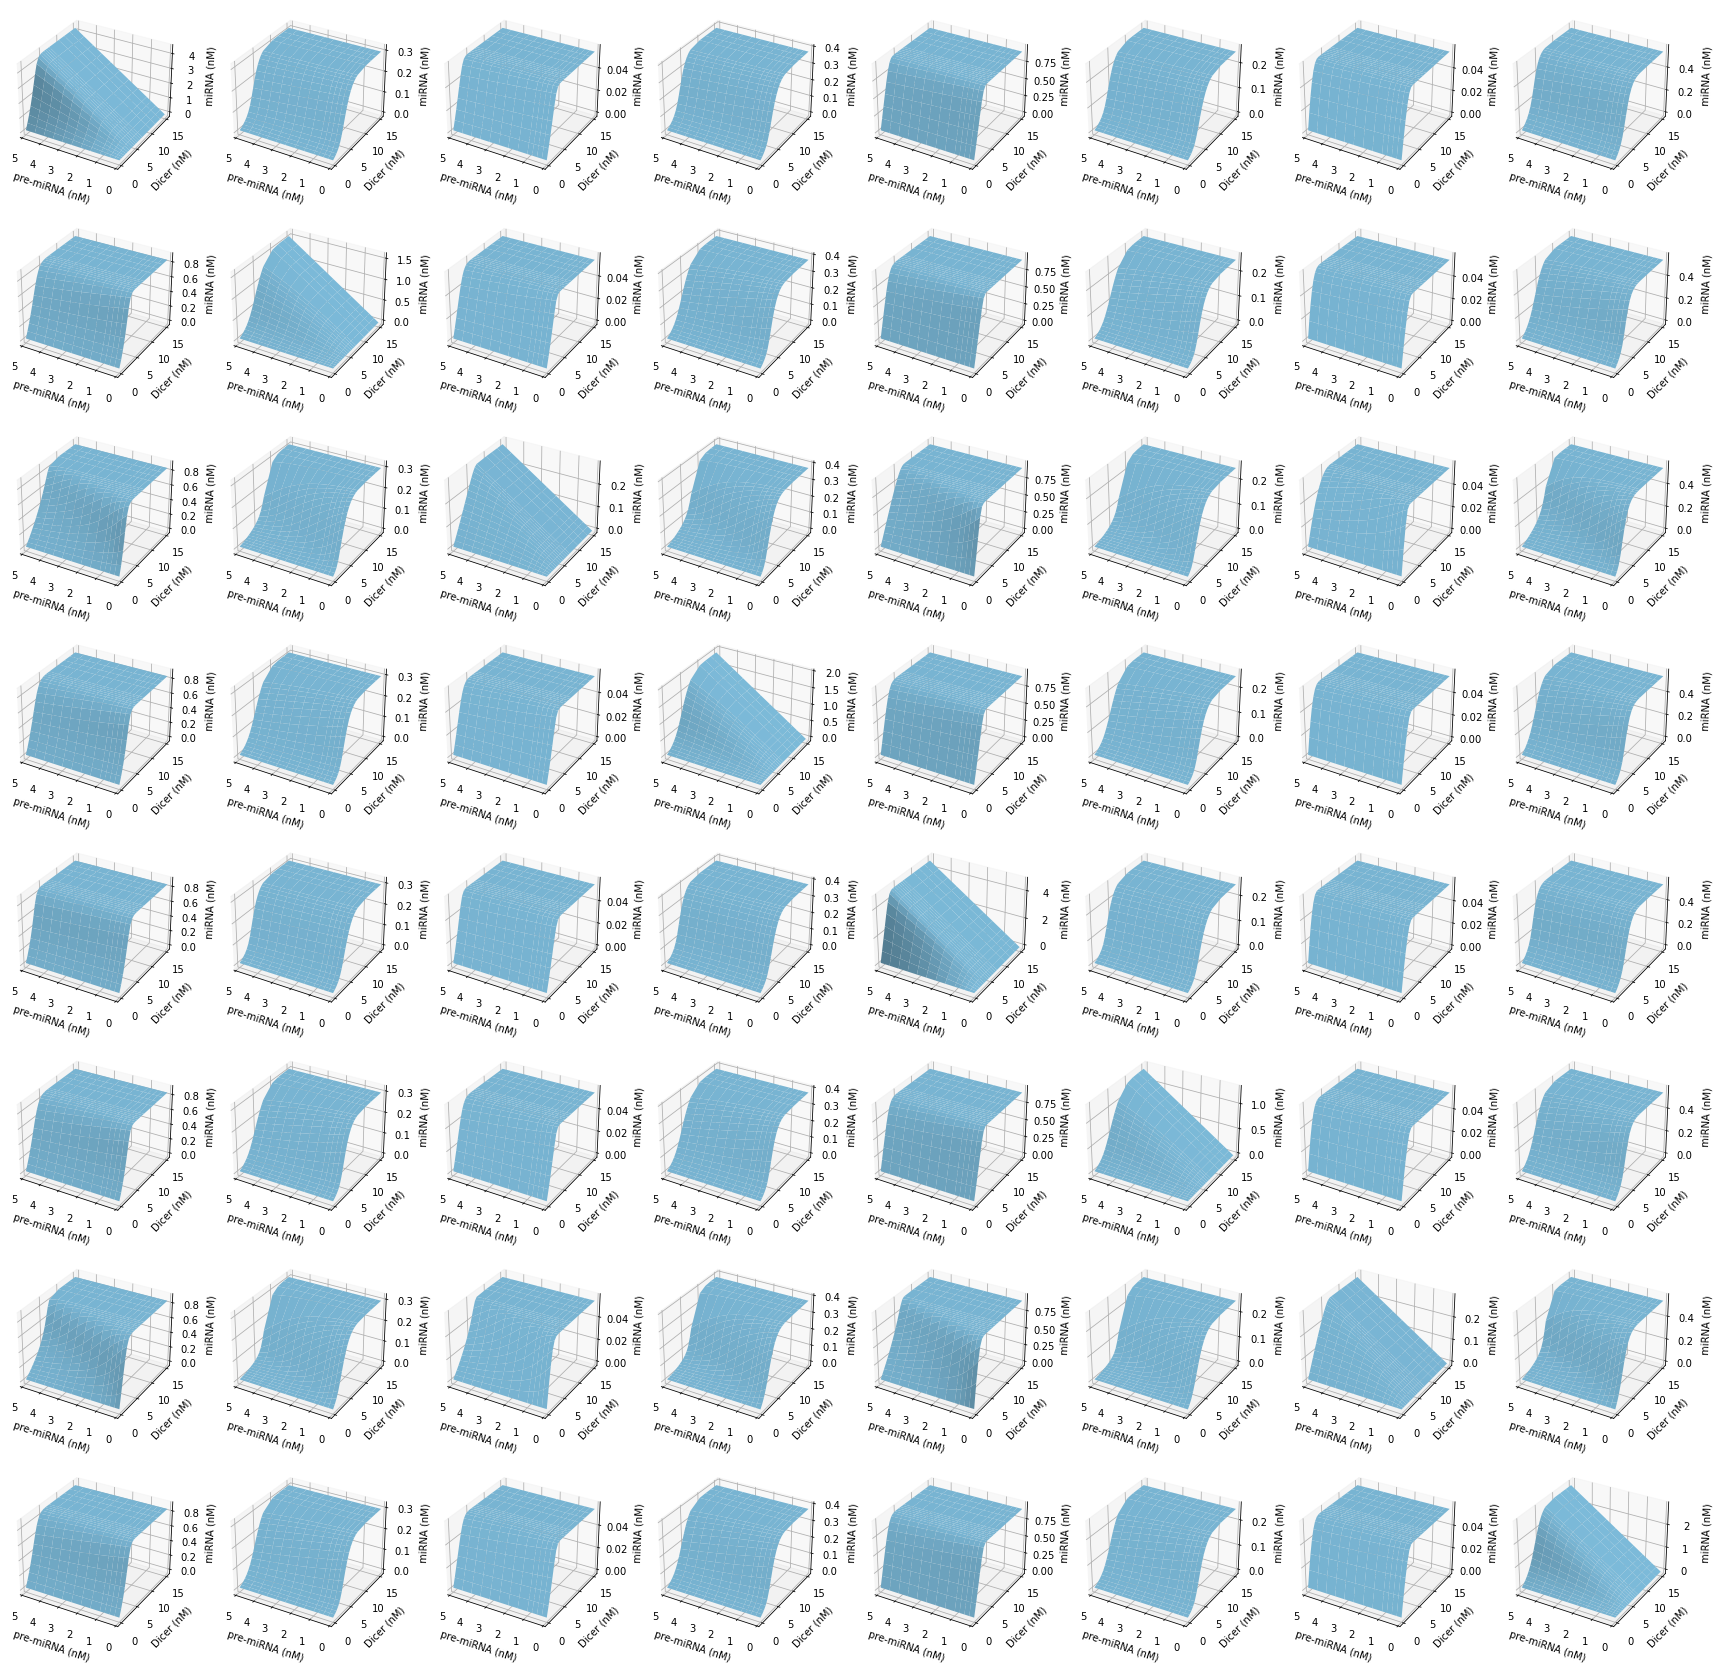

In [17]:
#plot 3d plots
fig = plt.figure(figsize = (30,30))
plot_ixs = np.arange(8*8).reshape((8,8))
plot_ixs = plot_ixs + np.ones((8,8))

for i in range(8):
    for j in range(8):
        exec('ax' + ' = fig.add_subplot(8, 8, ' + str(int(plot_ixs[i][j])) + ', projection = "3d")')
        
        x = dvars
        z = pvars
        x, z = np.meshgrid(x, z)
        y = ends['miR' + str(i) + '_changed'][j]
        ax.plot_surface(x,
                y,
                z,
                color = params.colors[0][1])
        ax.set_xlabel('Dicer (nM)')
        ax.set_ylabel('miRNA (nM)')
        ax.set_zlabel('pre-miRNA (nM)')
        ax.invert_zaxis()
        ax.view_init(vertical_axis = 'y')

#along x-axis: affected miRNA
#along y-axis: changed pre-miRNA

plt.savefig(destdir_figs + 'all_mirnas_matrix-surface.svg', dpi = 600, bbox_inches = 'tight')

plt.show()
                

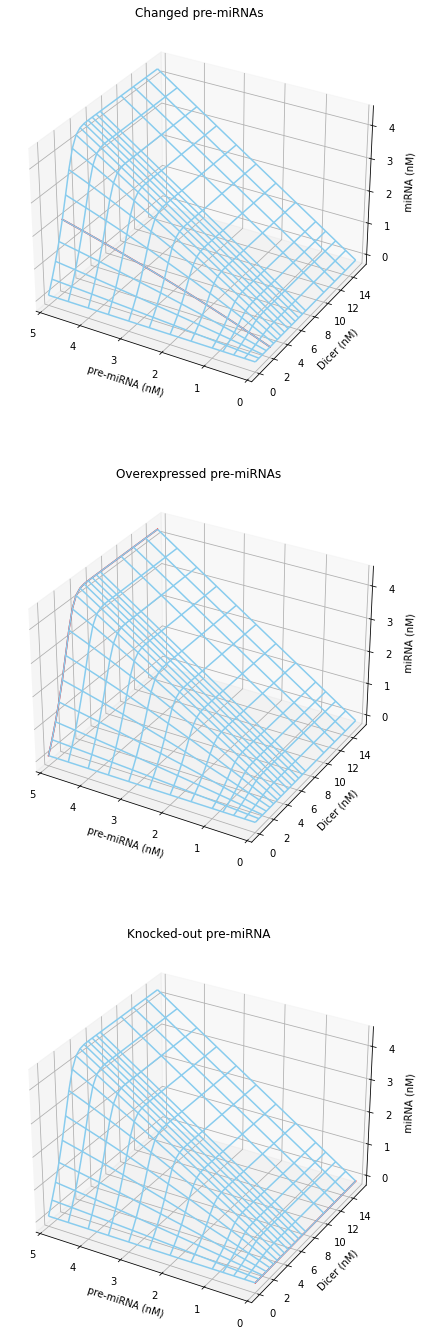

In [18]:
#plot example figures
fig = plt.figure(figsize = (8, int(8*3)))

x = dvars
z = pvars
X, Z = np.meshgrid(x, z)
y = ends['miR0_changed'][0]

#changed pre-miRNA concentration at ~2nM Dicer
ax1 = fig.add_subplot(3,1,1, projection = '3d')
ax1.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax1.set_xlabel('Dicer (nM)')
ax1.set_ylabel('miRNA (nM)')
ax1.set_zlabel('pre-miRNA (nM)')
ax1.invert_zaxis()
ax1.view_init(vertical_axis = 'y')


ax1.plot([dvars[4]] * len(y[:, 4]),
         y[:, 4],
         pvars,
         color = 'red')

ax1.set_title('Changed pre-miRNAs')

#overexpressed pre-miRNA
ax2 = fig.add_subplot(3,1,2, projection = '3d')
ax2.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax2.set_xlabel('Dicer (nM)')
ax2.set_ylabel('miRNA (nM)')
ax2.set_zlabel('pre-miRNA (nM)')
ax2.invert_zaxis()
ax2.view_init(vertical_axis = 'y')

ax2.plot(dvars,
         y[-1, :],
         [pvars[-1]]*len(dvars),
         color = 'red')
ax2.set_title('Overexpressed pre-miRNAs')

#knocked out pre-miRNA
ax3 = fig.add_subplot(3,1,3, projection = '3d')
ax3.plot_wireframe(X,
                y,
                Z,
                color = params.colors[0][1])
ax3.set_xlabel('Dicer (nM)')
ax3.set_ylabel('miRNA (nM)')
ax3.set_zlabel('pre-miRNA (nM)')
ax3.invert_zaxis()
ax3.view_init(vertical_axis = 'y')

ax3.plot(dvars,
         y[0, :],
         [pvars[0]]*len(dvars),
         color = 'red')
ax3.set_title('Knocked-out pre-miRNA')

plt.savefig(destdir_figs + 'example_figures.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [140]:
#subset data to plot following:
##effect of pre-miRNA concentration on competition when [Dicer] ~ 2 (dvars[4])
##effect of Dicer on sequentially knocked out pre-miRNAs ([pre-miRNA] = 0 (pvars[0])
##effect of Dicer on sequentially over-expressed pre-miRNAs ([pre-miRNA] = 5. (pvars[-1])
pmir_var = {}
pmir_ko = {}
pmir_oe = {}
pmir_pvar_ctrl = {}
pmir_dvar_ctrl = {}

ctrl_pmir_oe = {}
ctrl_pmir_ko = {}
ctrl_ctrl_dvar = {}
ctrl_ctrl_pvar = {}

for i in tqdm(range(8)):
    for j in range(8):
        exec('data = ends["miR' + str(i) + '_changed"][' + str(j) + ']')
        exec('control = control_ends["miR' + str(i) + '_changed"][' + str(j) + ']')
        
        if j == 0:
            pmir_var["miR" + str(i) + "_changed"] = np.array([data[:,4]])
            pmir_ko["miR" + str(i) + "_changed"] = np.array([data[np.where(pvars == 0)[0][0]]])
            pmir_oe["miR" + str(i) + "_changed"] = np.array([data[np.where(pvars == 5.)[0][0]]])
            pmir_pvar_ctrl["miR" + str(i) + "_changed"] = np.array([data[np.where(pvars == 1.)[0][0]]])
            pmir_dvar_ctrl["miR" + str(i) + "_changed"] = np.array([data[:, np.where(dvars == 15.)[0][0]]])
            
            ctrl_pmir_ko["miR" + str(i) + "_changed"] = np.array([control[np.where(pvars == 0)[0][0]]])
            ctrl_pmir_oe["miR" + str(i) + "_changed"] = np.array([control[np.where(pvars == 5.)[0][0]]])
            ctrl_ctrl_dvar["miR" + str(i) + "_changed"] = np.array([control[:, np.where(dvars == 15.)[0][0]]])
            ctrl_ctrl_pvar["miR" + str(i) + "_changed"] = np.array([control[np.where(pvars == 1.)[0][0]]])
        else:
            pmir_var["miR" + str(i) + "_changed"] = np.vstack((pmir_var["miR" + str(i) + "_changed"], data[:,4]))
            pmir_ko["miR" + str(i) + "_changed"] = np.vstack((pmir_ko["miR" + str(i) + "_changed"], data[np.where(pvars == 0.)[0][0]]))
            pmir_oe["miR" + str(i) + "_changed"] = np.vstack((pmir_oe["miR" + str(i) + "_changed"], data[np.where(pvars == 5.)[0][0]]))
            pmir_pvar_ctrl["miR" + str(i) + "_changed"] = np.vstack((pmir_pvar_ctrl["miR" + str(i) + "_changed"], data[np.where(pvars == 1.)[0][0]]))
            pmir_dvar_ctrl["miR" + str(i) + "_changed"] = np.vstack((pmir_dvar_ctrl["miR" + str(i) + "_changed"], data[:, np.where(dvars == 15.)[0][0]]))
            
            ctrl_pmir_ko["miR" + str(i) + "_changed"] = np.vstack((ctrl_pmir_ko["miR" + str(i) + "_changed"], control[np.where(pvars == 0.)[0][0]]))
            ctrl_pmir_oe["miR" + str(i) + "_changed"] = np.vstack((ctrl_pmir_oe["miR" + str(i) + "_changed"], control[np.where(pvars == 5.)[0][0]]))
            ctrl_ctrl_dvar["miR" + str(i) + "_changed"] = np.vstack((ctrl_ctrl_dvar["miR" + str(i) + "_changed"], control[:, np.where(dvars == 15.)[0][0]]))
            ctrl_ctrl_pvar["miR" + str(i) + "_changed"] = np.vstack((ctrl_ctrl_pvar["miR" + str(i) + "_changed"], control[np.where(pvars == 1.)[0][0]]))

100%|██████████| 8/8 [00:00<00:00, 854.32it/s]


In [141]:
#Isolate mature miRNA concentration at dvars[4] for oe, ko data
mir_oe = {}
mir_ko = {}
control_oe = {}
control_ko = {}

for i in tqdm(range(8)):
    for j in range(8):
        exec('data = ends["miR' + str(i) + '_changed"][' + str(j) + ']')
        exec('control = control_ends["miR' + str(i) + '_changed"][' + str(j) + ']')
        
        if j == 0:
            mir_ko["miR" + str(i) + "_changed"] = [data[np.where(pvars == 0)][0][4]/data[np.where(pvars == 1)][0][4]]
            mir_oe["miR" + str(i) + "_changed"] = [data[np.where(pvars == 5.)][0][4]/data[np.where(pvars == 1)][0][4]]
            control_ko["miR" + str(i) + "_changed"] = [control[np.where(pvars == 0)][0][4]/control[np.where(pvars == 1)][0][4]]
            control_oe["miR" + str(i) + "_changed"] = [control[np.where(pvars == 5.)][0][4]/control[np.where(pvars == 1)][0][4]]
        else:
            mir_ko["miR" + str(i) + "_changed"].append(data[np.where(pvars == 0.)][0][4]/data[np.where(pvars == 1)][0][4])
            mir_oe["miR" + str(i) + "_changed"].append(data[np.where(pvars == 5.)][0][4]/data[np.where(pvars == 1.)][0][4])
            control_ko["miR" + str(i) + "_changed"].append(control[np.where(pvars == 0.)][0][4]/control[np.where(pvars == 1)][0][4])
            control_oe["miR" + str(i) + "_changed"].append(control[np.where(pvars == 5.)][0][4]/control[np.where(pvars == 1.)][0][4])

100%|██████████| 8/8 [00:00<00:00, 1464.04it/s]


In [97]:
#prep for plotting heatmaps
index = ['miR' + str(i) for i in range(8)]
df_mir_oe = pd.DataFrame(mir_oe, index = index)
df_mir_oe = df_mir_oe.transpose()
df_mir_ko = pd.DataFrame(mir_ko, index = index)
df_mir_ko = df_mir_ko.transpose()
df_control_oe = pd.DataFrame(control_oe, index = index)
df_control_oe = df_control_oe.transpose()
df_control_ko = pd.DataFrame(control_ko, index = index)
df_control_ko = df_control_ko.transpose()

#reorder columns
col_order = ['miR0', 'miR4', 'miR1', 'miR5', 'miR2', 'miR6', 'miR3', 'miR7']
index_order = [i + '_changed' for i in col_order]

df_mir_oe = df_mir_oe[col_order]
df_mir_oe = df_mir_oe.reindex(index_order)
df_mir_ko = df_mir_ko[col_order]
df_mir_ko = df_mir_ko.reindex(index_order)
df_control_oe = df_control_oe[col_order]
df_control_oe = df_control_oe.reindex(index_order)
df_control_ko = df_control_ko[col_order]
df_control_ko = df_control_ko.reindex(index_order)

In [ ]:
custom_cmap = ["#f5fa6e", "#ccf073", "#a6e47a", "#82d781", "#61c888", "#40b98d", "#1fa990",
                  "#00998f", "#00888b", "#007883", "#176777", "#245769", "#2a4858"]
custom_cmap_r = ["#2a4858", "#245769", "#176777", "#007883", "#00888b", "#00998f",
                 "#1fa990", "#40b98d", "#61c888", "#82d781", "#a6e47a", "#ccf073", "#f5fa6e"]

### miRNA plots

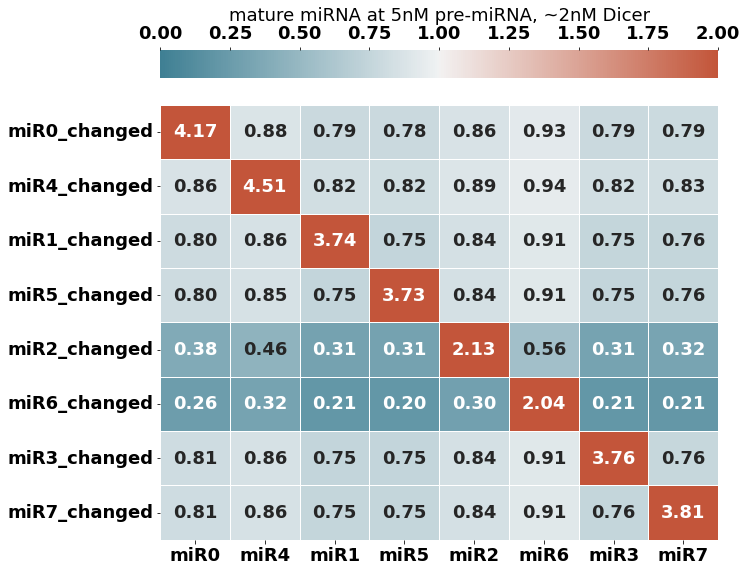

In [99]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')
ax = sns.heatmap(df_mir_oe,
                      annot = True,
                      linewidth =  1,
                      #cmap = mcolors.ListedColormap(custom_cmap_r),
                      #cmap = sns.color_palette("crest", as_cmap=True),
                      cbar_kws = {'location': 'top',
        
                                  'label': 'mature miRNA at 5nM pre-miRNA, ~2nM Dicer'},
                      cmap = sns.diverging_palette(220, 20, as_cmap=True),
                      center = 1.,
                      vmax = 2.,
                      vmin = 0.,
                      fmt = '.2f'
                     )

plt.savefig(destdir_figs + 'mir_oe_comp.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

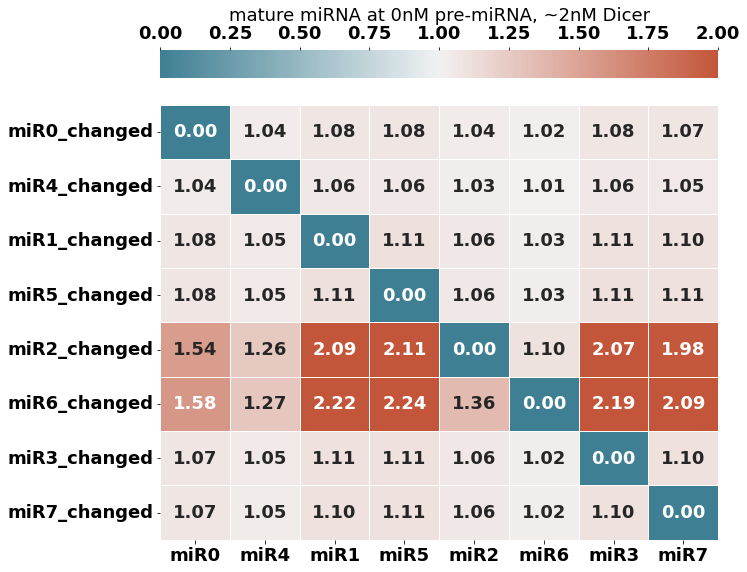

In [100]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')

ax = sns.heatmap(df_mir_ko,
                      annot = True,
                      linewidth =  1,
                      #cmap = mcolors.ListedColormap(custom_cmap_r),
                      #cmap = sns.color_palette("crest", as_cmap=True),
                      cbar_kws = {'location': 'top',
        
                                  'label': 'mature miRNA at 0nM pre-miRNA, ~2nM Dicer'},
                      cmap = sns.diverging_palette(220, 20, as_cmap=True),
                      center = 1.,
                      vmax = 2.,
                      vmin = 0.,
                      fmt = '.2f'
                     )


plt.savefig(destdir_figs + 'mir_ko_comp.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

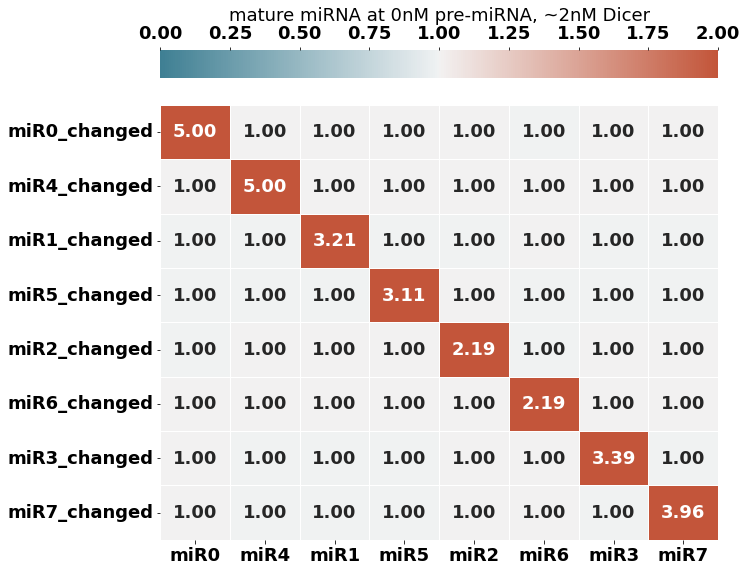

In [101]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')

ax = sns.heatmap(df_control_oe,
                      annot = True,
                      linewidth =  1,
                      #cmap = mcolors.ListedColormap(custom_cmap_r),
                      #cmap = sns.color_palette("crest", as_cmap=True),
                      cbar_kws = {'location': 'top',
        
                                  'label': 'mature miRNA at 0nM pre-miRNA, ~2nM Dicer'},
                      cmap = sns.diverging_palette(220, 20, as_cmap=True),
                      center = 1.,
                      vmax = 2.,
                      vmin = 0.,
                      fmt = '.2f'
                     )

plt.savefig(destdir_figs + 'mir_oe_ctrl.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

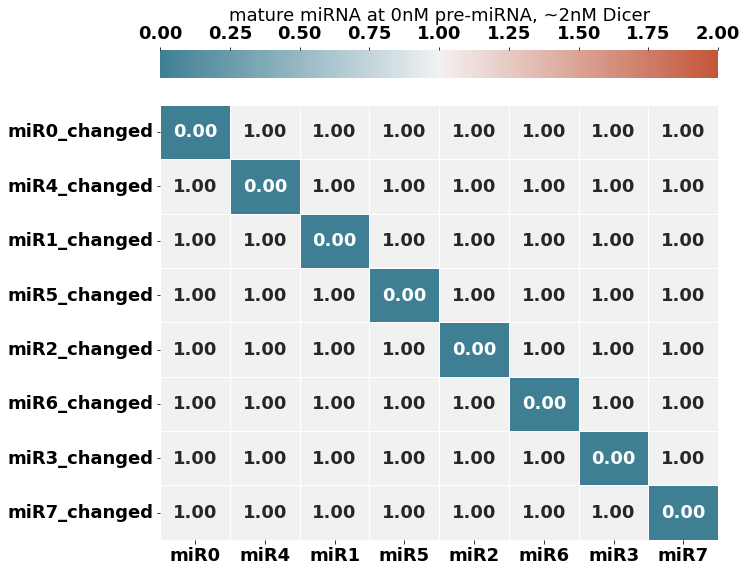

In [102]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')

ax = sns.heatmap(df_control_ko,
                      annot = True,
                      linewidth =  1,
                      #cmap = mcolors.ListedColormap(custom_cmap_r),
                      #cmap = sns.color_palette("crest", as_cmap=True),
                      cbar_kws = {'location': 'top',
        
                                  'label': 'mature miRNA at 0nM pre-miRNA, ~2nM Dicer'},
                      cmap = sns.diverging_palette(220, 20, as_cmap=True),
                      center = 1.,
                      vmax = 2.,
                      vmin = 0.,
                      fmt = '.2f'
                     )

plt.savefig(destdir_figs + 'mir_ko_ctrl.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [199]:
#calculate aucs (integral), sums
###normalised to 1nM pMiR, 15nM Dicer
var_auc = {}
oe_auc = {}
ko_auc = {} 

for key in pmir_var.keys():
    var_auc[key] = []
    oe_auc[key] = []
    ko_auc[key] = []
    for i in range(len(pmir_var)):
        var_auc[key].append(simpson(y = pmir_var[key][i],
                                      x = pvars,
                                      even = 'abs')/simpson(y = pmir_dvar_ctrl[key][i],
                                                           x = pvars, even  = 'abs'))
        oe_auc[key].append(simpson(y = pmir_oe[key][i],
                                     x = dvars,
                                     even = 'abs')/simpson(y = pmir_pvar_ctrl[key][i],
                                                           x = dvars, even  = 'abs'))
        ko_auc[key].append(simpson(y = pmir_ko[key][i],
                                     x = dvars,
                                     even = 'abs')/simpson(y = pmir_pvar_ctrl[key][i],
                                                           x = dvars, even  = 'abs'))

C:\Users\op20001\AppData\Local\Temp/ipykernel_8076/3213073745.py:12: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  var_auc[key].append(simpson(y = pmir_var[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8076/3213073745.py:14: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  even = 'abs')/simpson(y = pmir_dvar_ctrl[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8076/3213073745.py:16: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  oe_auc[key].append(simpson(y = pmir_oe[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8076/3213073745.py:18: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  even = 'abs')/simpson(y = pmir_pvar_ctrl[key][i],
C:\Users\op20001\AppData\Local\Temp/ipykernel_8076/3213073745.py:20: DeprecationWarnin

In [200]:
index = ['miR' + str(i) for i in range(8)]
df_var_auc = pd.DataFrame(var_auc, index = index)
df_var_auc = df_var_auc.transpose()
df_oe_auc = pd.DataFrame(oe_auc, index = index)
df_oe_auc = df_oe_auc.transpose()
df_ko_auc = pd.DataFrame(ko_auc, index = index)
df_ko_auc = df_ko_auc.transpose()

#re-order  columns, index
df_var_auc = df_var_auc[col_order]
df_var_auc = df_var_auc.reindex(index_order)
df_oe_auc = df_oe_auc[col_order]
df_oe_auc = df_oe_auc.reindex(index_order)
df_ko_auc = df_ko_auc[col_order]
df_ko_auc = df_ko_auc.reindex(index_order)

### secant plots

In [142]:
#calculate slopes of secants (hacky differential), sums
##normalised to 1nM pre-miRNA, ~15nM Dicer
var = {}
oe = {}
ko = {}
oe_ctrl = {}
ko_ctrl = {}

dx_pvar = np.diff(pvars)
dx_dvar = np.diff(dvars)

for key in pmir_var.keys():
    var[key] = []
    oe[key] = []
    ko[key] = []
    oe_ctrl[key] = []
    ko_ctrl[key] = []
    for i in range(len(pmir_var)):
        var[key].append(np.sum(abs(np.diff(pmir_var[key][i])/dx_pvar))/np.sum(abs(np.diff(ctrl_ctrl_dvar[key][i])/dx_pvar)))
        oe[key].append(np.sum(abs(np.diff(pmir_oe[key][i])/dx_dvar))/np.sum(abs(np.diff(pmir_pvar_ctrl[key][i])/dx_dvar)))
        ko[key].append(np.sum(abs(np.diff(pmir_ko[key][i])/dx_dvar))/np.sum(abs(np.diff(pmir_pvar_ctrl[key][i])/dx_dvar)))
        
        oe_ctrl[key].append(np.sum(abs(np.diff(ctrl_pmir_oe[key][i])/dx_dvar))/np.sum(abs(np.diff(ctrl_ctrl_pvar[key][i])/dx_dvar)))
        ko_ctrl[key].append(np.sum(abs(np.diff(ctrl_pmir_ko[key][i])/dx_dvar))/np.sum(abs(np.diff(ctrl_ctrl_pvar[key][i])/dx_dvar)))

In [143]:
index = ['miR' + str(i) for i in range(8)]
df_var = pd.DataFrame(var, index = index)
df_var = df_var.transpose()
df_oe = pd.DataFrame(oe, index = index)
df_oe = df_oe.transpose()
df_ko = pd.DataFrame(ko, index = index)
df_ko = df_ko.transpose()
df_oe_ctrl = pd.DataFrame(oe_ctrl, index = index)
df_oe_ctrl = df_oe_ctrl.transpose()
df_ko_ctrl = pd.DataFrame(ko_ctrl, index = index)
df_ko_ctrl = df_ko_ctrl.transpose()

#reorder columns
col_order = ['miR0', 'miR4', 'miR1', 'miR5', 'miR2', 'miR6', 'miR3', 'miR7']
index_order = [i + '_changed' for i in col_order]

df_var = df_var[col_order]
df_var = df_var.reindex(index_order)
df_oe = df_oe[col_order]
df_oe = df_oe.reindex(index_order)
df_ko = df_ko[col_order]
df_ko = df_ko.reindex(index_order)
df_oe_ctrl = df_oe_ctrl[col_order]
df_oe_ctrl = df_oe_ctrl.reindex(index_order)
df_ko_ctrl = df_ko_ctrl[col_order]
df_ko_ctrl = df_ko_ctrl.reindex(index_order)

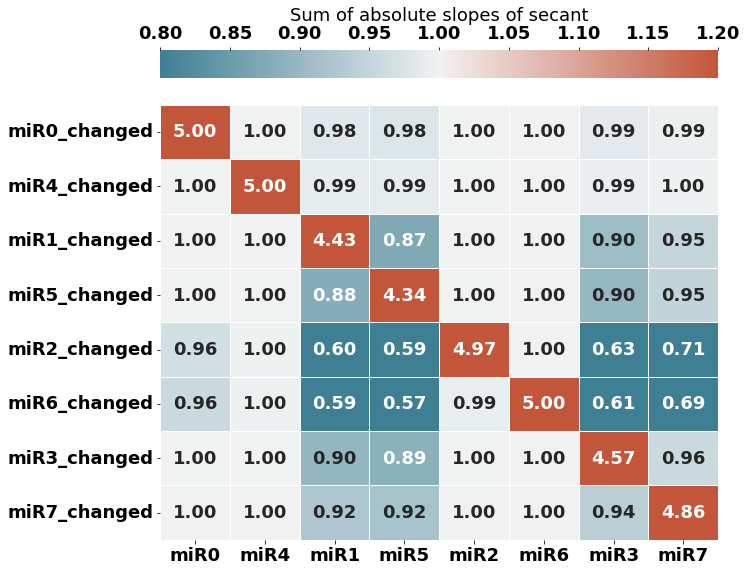

In [144]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')
ax = sns.heatmap(df_oe,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'oe_secant_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

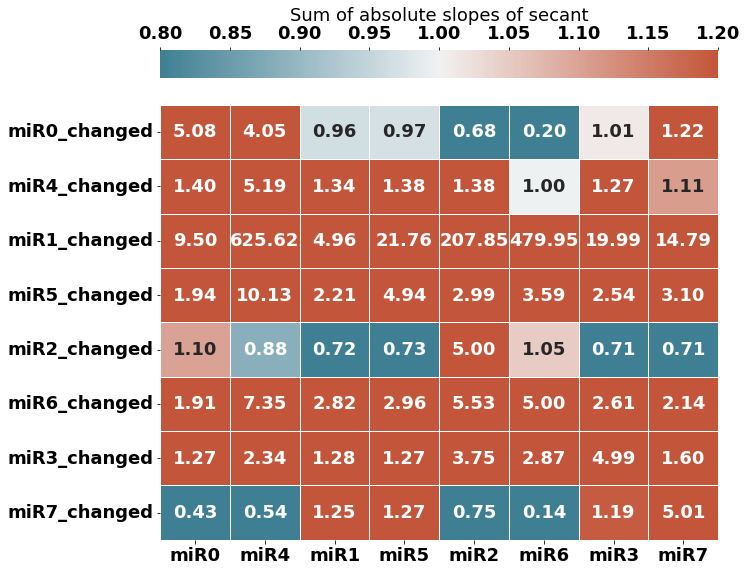

In [145]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 18, weight = 'bold')
ax = sns.heatmap(df_oe_ctrl,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'oe_ctrl_secant_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

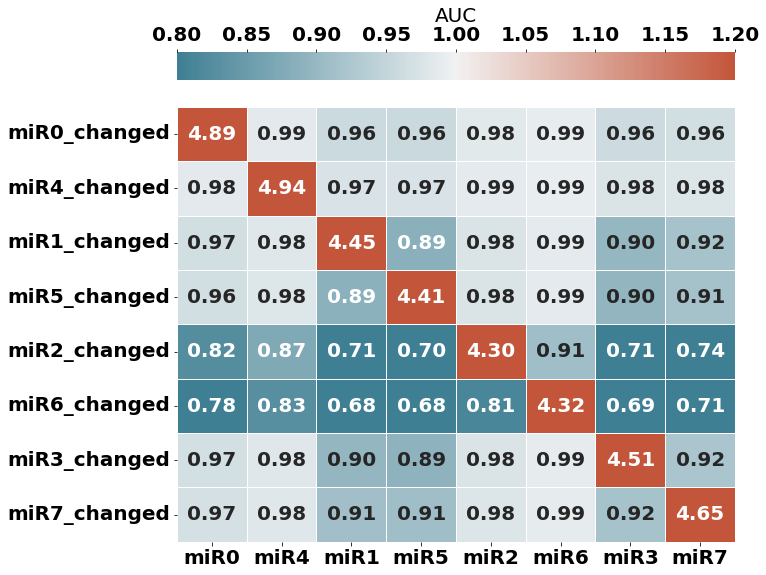

In [187]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(df_oe_auc,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'AUC'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'oe_auc_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

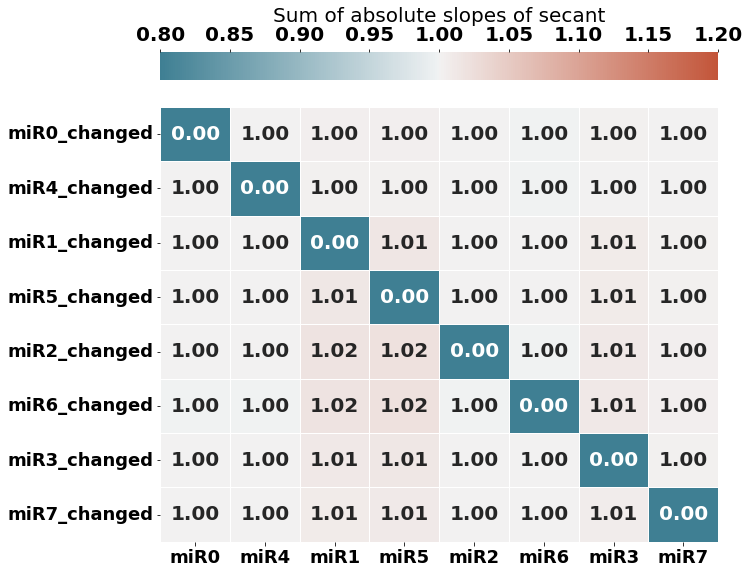

In [146]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(df_ko,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'ko_secant_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

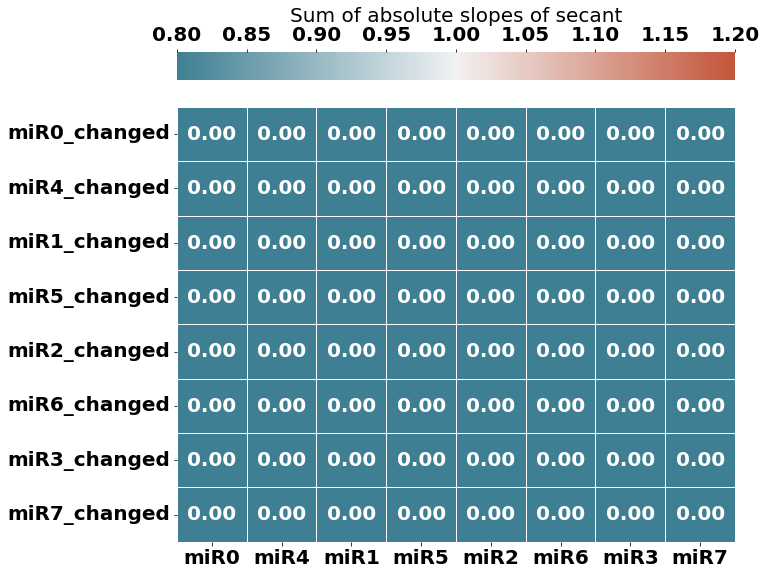

In [147]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(df_ko_ctrl,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Sum of absolute slopes of secant'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'ko_ctrl_secant_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

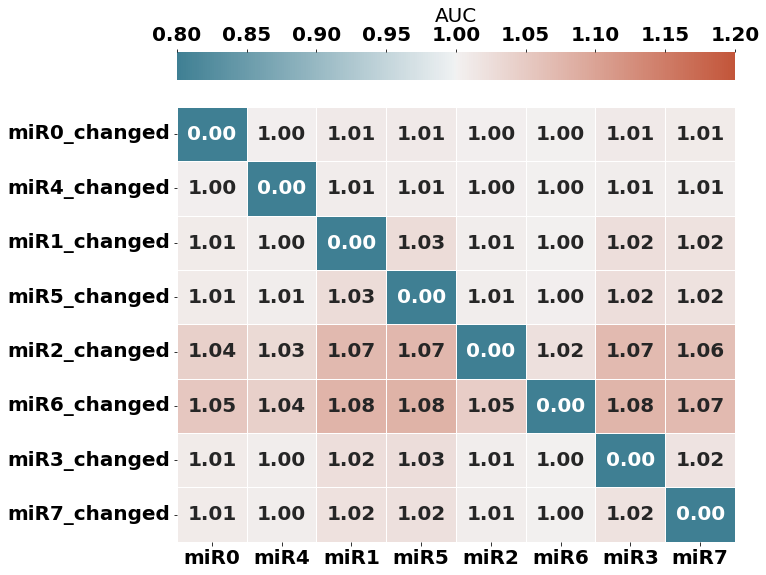

In [189]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(df_ko_auc,
                annot = True,
                linewidth =  1,
                #cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'AUC'},
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                center = 1.,
                vmax = 1.2,
                vmin = 0.8,
                fmt = '.2f'
                )

plt.savefig(destdir_figs + 'ko_auc_normd.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
#hacky surface differentiation for compressing surface plot to single number for heatmap
diffs = np.zeros((8,8))

for i in tqdm(range(8)):
    for j in range(8):
        diff = []
        for k in range(len(pvars)):
            y = ends['miR' + str(i) + '_changed'][j][k]
            dy = np.sum(abs(np.diff(y)/np.diff(dvars)))
            
            diff += [dy]
        
        diffs[i][j] = np.sum(abs(np.diff(np.array(diff))/np.diff(pvars)))

In [ ]:
#for example plotting
diff = []
for k in range(len(pvars)):
    y = ends['miR0_changed'][0][k]
    dy = np.sum(abs(np.diff(y)/np.diff(dvars)))
            
    diff += [dy]

In [ ]:
colnames = ['miR' + str(i) for i in range(8)]
index = list(ends.keys())
diff_df = pd.DataFrame(diffs, columns = colnames, index = index)
#reorder
diff_df = diff_df[col_order]
diff_df = diff_df.reindex(index_order)

In [ ]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(diff_df,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Hacky surface "differential"'},
                vmax = 2,
                fmt = '.1f'
                )

plt.savefig(destdir_figs + 'hacky_surface_differentiated.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
#hacky surface integration for compressing surface plot to single number for heatmap
aucs = np.zeros((8,8))

for i in tqdm(range(8)):
    for j in range(8):
        auc = []
        for k in range(len(pvars)):
            y = ends['miR' + str(i) + '_changed'][j][k]
            integrated = simpson(y = y,
                                 x = dvars,
                                 even = 'avg')
            
            auc += [integrated]
        
        aucs[i][j] = simpson(y = auc,
                                x = pvars,
                                even = 'avg')

In [ ]:
#for example plotting
auc = []
for k in range(len(pvars)):
    y = ends['miR0_changed'][0][k]
    integrated = simpson(y = y,
                         x = dvars,
                         even = 'avg')
            
    auc += [integrated]

In [ ]:
auc_df = pd.DataFrame(aucs, columns = colnames, index = index)
#reorder
auc_df = auc_df[col_order]
auc_df = auc_df.reindex(index_order)

In [ ]:
fig = plt.subplots(figsize = (10, 10))
plt.rc('font', size = 20, weight = 'bold')
ax = sns.heatmap(auc_df,
                annot = True,
                linewidth =  1,
                cmap = mcolors.ListedColormap(custom_cmap_r),
                #cmap = sns.color_palette("crest", as_cmap=True),
                cbar_kws = {'location': 'top',
                            'label': 'Hacky surface "integral"'},
                vmax = 60,
                fmt = '.0f'
                )

plt.savefig(destdir_figs + 'hacky_surface_integrated.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [ ]:
#example plot
fig, ax  = plt.subplots(2, sharex = True, figsize = (6, 10))

ax[0].plot(pvars,
           diff,
          color = custom_cmap_r[3])

ax[0].set_ylabel(r'diffs')

ax[1].plot(pvars,
           auc,
          color = custom_cmap_r[3])
ax[1].set_ylabel('AUC, mature miRNA over Dicer')
ax[1].set_xlabel(r'pre-miRNA (nM)')

plt.savefig(destdir_figs + 'example_plots_surface2.svg', dpi = 600, bbox_inches = 'tight')

plt.show()